## Preamble

### Project Template

In [1]:
%load_ext autoreload

In [2]:
import os as _os

_os.chdir(_os.environ["PROJECT_ROOT"])
_os.path.realpath(_os.path.curdir)

'/pollard/data/projects/bsmith/strain-corr'

### Imports

In [3]:
import os
import subprocess
import sys
import time
from datetime import datetime
from glob import glob
from itertools import chain, product
from tempfile import mkstemp

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
import sfacts as sf
import statsmodels.api as sm
import statsmodels.formula.api as smf
import xarray as xr
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.spatial.distance import squareform
from statsmodels.stats.multitest import fdrcorrection
from tqdm import tqdm

import lib.plot
from lib.pandas_util import align_indexes, aligned_index, idxwhere, invert_mapping
from lib.thisproject.genotype_dissimilarity import native_masked_hamming_distance_cdist

/pollard/home/bsmith/.snakemake/conda/8dd43b17b83f3accb639079fe0075b14_/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Style

In [4]:
sns.set_context("paper")
plt.rcParams["figure.dpi"] = 100

## Analysis Parameters

In [5]:
ambiguity_threshold = 0.1

# Load and Check Data

## Select some GTDB genomes missing from UHGG

### Pick some examples genomes and generate the necessary metadata files.

In [6]:
prjna938932_genomes = pd.read_table(
    "raw/PRJNA938932_AssemblyDetails.txt",
    skiprows=2,
    names=["assembly_id", "level", "wgs", "biosample", "strain", "taxonomy", "_"],
)
prjna938932_genomes

,assembly_id,level,wgs,biosample,strain,taxonomy,_
0,GCA_030235005.1,Contig,JARIXJ000000000,SAMN33450454,2SOBe24c,Escherichia coli,NaN
1,GCA_030234965.1,Contig,JARIXI000000000,SAMN33450455,2SOBe25c,Escherichia coli,NaN
2,GCA_030234945.1,Contig,JARIXG000000000,SAMN33450457,2SOBe2cB,Escherichia coli,NaN
3,GCA_030234925.1,Contig,JARIXH000000000,SAMN33450456,2SOBe2cA,Escherichia coli,NaN
4,GCA_030234905.1,Contig,JARIXF000000000,SAMN33450458,2SOBe3c,Escherichia coli,NaN
...,...,...,...,...,...,...,...
402,GCA_030219865.1,Contig,JARIUI000000000,SAMN33450123,1SHAe10cef,Escherichia coli,NaN
403,GCA_030219845.1,Contig,JARIUH000000000,SAMN33450124,1SHAe11cef,Escherichia coli,NaN
404,GCA_030219825.1,Contig,JARIUF000000000,SAMN33450126,1SHAe13cef,Escherichia coli,NaN
405,GCA_030219805.1,Contig,JARIUA000000000,SAMN33450131,1SHAe18cef,Escherichia coli,NaN


In [7]:
def table_description(df):
    return pd.DataFrame(
        dict(col_idx=range(df.shape[1]), name=df.columns, example_val=df.iloc[0].values)
    ).set_index("col_idx")


table_description(prjna938932_genomes)

,name,example_val
col_idx,,
0,assembly_id,GCA_030235005.1
1,level,Contig
2,wgs,JARIXJ000000000
3,biosample,SAMN33450454
4,strain,2SOBe24c
5,taxonomy,Escherichia coli
6,_,NaN


In [8]:
genome_meta = pd.read_table("meta/genome.tsv")

table_description(genome_meta)

# for i, (c, v) in enumerate(zip(genome_meta.columns, genome_meta.iloc[0].values)):
#     print(i, c, v, sep="\t")

,name,example_val
col_idx,,
0,genome_id,Escherichia-coli-GCF_030198155-1
1,species_id,102506
2,genome_path,raw/genomes/ncbi/Escherichia-coli-GCF_03019815...
3,_old_genome_id,NaN
4,ncbi_assembly_name,GCA_030198155.1
5,ncbi_assembly_biosample,SAMN33450452
6,comments,From PRJNA938932 GCA_030198155.1;


In [9]:
genome_group_meta = pd.read_table("meta/genome_group.tsv")


table_description(genome_group_meta)

# for i, (c, v) in enumerate(
#     zip(genome_group_meta.columns, genome_group_meta.iloc[0].values)
# ):
#     print(i, c, v, sep="\t")

,name,example_val
col_idx,,
0,genome_id,Escherichia-coli-GCF_030205875-1
1,genome_group_id,spikein_benchmark_isolate


In [10]:
mgen_meta = pd.read_table("meta/mgen_to_reads.tsv")


table_description(mgen_meta)

# for i, (c, v) in enumerate(zip(mgen_meta.columns, mgen_meta.iloc[0].values)):
#     print(i, c, v, sep="\t")

,name,example_val
col_idx,,
0,mgen_id,Escherichia-coli-GCF_030198155-1
1,preprocessing,dedup.deadapt.qtrim
2,r1_path,raw/genomes/ncbi/Escherichia-coli-GCF_03019815...
3,r2_path,raw/genomes/ncbi/Escherichia-coli-GCF_03019815...


In [11]:
mgen_group_meta = pd.read_table("meta/mgen_group.tsv")


table_description(mgen_group_meta)

# for i, (c, v) in enumerate(
#     zip(mgen_group_meta.columns, mgen_group_meta.iloc[0].values)
# ):
#     print(i, c, v, sep="\t")

,name,example_val
col_idx,,
0,mgen_id,Escherichia-coli-GCF_030205875-1
1,mgen_group_id,spikein_benchmark_isolate


In [12]:
prjna938932_genomes

,assembly_id,level,wgs,biosample,strain,taxonomy,_
0,GCA_030235005.1,Contig,JARIXJ000000000,SAMN33450454,2SOBe24c,Escherichia coli,NaN
1,GCA_030234965.1,Contig,JARIXI000000000,SAMN33450455,2SOBe25c,Escherichia coli,NaN
2,GCA_030234945.1,Contig,JARIXG000000000,SAMN33450457,2SOBe2cB,Escherichia coli,NaN
3,GCA_030234925.1,Contig,JARIXH000000000,SAMN33450456,2SOBe2cA,Escherichia coli,NaN
4,GCA_030234905.1,Contig,JARIXF000000000,SAMN33450458,2SOBe3c,Escherichia coli,NaN
...,...,...,...,...,...,...,...
402,GCA_030219865.1,Contig,JARIUI000000000,SAMN33450123,1SHAe10cef,Escherichia coli,NaN
403,GCA_030219845.1,Contig,JARIUH000000000,SAMN33450124,1SHAe11cef,Escherichia coli,NaN
404,GCA_030219825.1,Contig,JARIUF000000000,SAMN33450126,1SHAe13cef,Escherichia coli,NaN
405,GCA_030219805.1,Contig,JARIUA000000000,SAMN33450131,1SHAe18cef,Escherichia coli,NaN


In [13]:
prjna938932_genomes

d = prjna938932_genomes.assign(
    genome_id=lambda x: "Escherichia-coli-"
    + x.assembly_id.str.replace("GCA", "GCF").str.replace(".1$", "-1", regex=True),
    mgen_id=lambda x: x.genome_id,
    species_id="102506",
    genome_path=lambda x: "raw/genomes/ncbi/" + x.genome_id + "/assembly.fa",
    r1_path=lambda x: "raw/genomes/ncbi/" + x.genome_id + "/r1.fq.gz",
    r2_path=lambda x: "raw/genomes/ncbi/" + x.genome_id + "/r2.fq.gz",
    genome_group_id="potential_spikein_benchmark",
    mgen_group_id="potential_spikein_benchmark",
    preprocessing="noop",
    _old_genome_id="",
    ncbi_assembly_name=lambda x: x.assembly_id,
    ncbi_assembly_biosample=lambda x: x.biosample,
    comments=lambda x: "From PRJNA938932 " + x.assembly_id + ";",
).sort_values("genome_id")


d[genome_meta.columns].to_csv(
    "meta/prjna938932_ecoli_genome.tsv", index=False, sep="\t"
)
d[genome_group_meta.columns].to_csv(
    "meta/prjna938932_ecoli_genome_group.tsv", index=False, sep="\t"
)
d[mgen_group_meta.columns].to_csv(
    "meta/prjna938932_ecoli_mgen_group.tsv", index=False, sep="\t"
)
d[mgen_meta.columns].to_csv(
    "meta/prjna938932_ecoli_mgen_to_reads.tsv", index=False, sep="\t"
)

## Load metadata

In [14]:
uhgg_genome_meta = pd.read_table('ref/midasdb_uhgg_v20/metadata/genomes-all_metadata.tsv', index_col='New_Genome_accession')

## Compare Genotypes

In [15]:
species = "102506"

In [16]:
midas_assembly_inpath = f"data/species/sp-{species}/midasdb_v15.gtpro.mgtp.nc"
midas_assembly_geno = (
    sf.Metagenotype.load(midas_assembly_inpath).to_estimated_genotype()
    # .discretized(max_ambiguity=ambiguity_threshold)
)

In [17]:
spikein_assembly_inpath = f"data/group/potential_spikein_benchmark/species/sp-{species}/strain_genomes.gtpro.mgtp.nc"
spikein_assembly_geno = (
    sf.Metagenotype.load(spikein_assembly_inpath).to_estimated_genotype()
    # .discretized(max_ambiguity=ambiguity_threshold)
)

In [18]:
hmp2_inferred_inpath = (
    f"data/group/hmp2/species/sp-{species}/r.proc.gtpro.sfacts-fit.spgc_ss-all.mgtp.nc"
)
hmp2_inferred_geno = (
    sf.Metagenotype.load(hmp2_inferred_inpath).to_estimated_genotype()
    # .discretized(max_ambiguity=ambiguity_threshold)
)

In [19]:
g1 = spikein_assembly_geno.discretized(max_ambiguity=ambiguity_threshold)
g2 = hmp2_inferred_geno.discretized(max_ambiguity=ambiguity_threshold)

g0 = sf.data.Genotype.concat(
    {
        "spike": g1,
        "hmp2": g2,
    },
    dim="strain",
    rename=False,
)

spikein_and_hmp2_sample_geno = g0

g0 = spikein_and_hmp2_sample_geno_ss = g0.random_sample(position=10_000)

spikein_to_hmp2_gdist = native_masked_hamming_distance_cdist(
    g0.sel(strain=g1.strain).values,
    g0.sel(strain=g2.strain).values,
)
spikein_to_hmp2_gdist = pd.DataFrame(
    spikein_to_hmp2_gdist,
    index=g1.strain,
    columns=g2.strain,
)

In [20]:
g1 = spikein_assembly_geno.discretized(max_ambiguity=ambiguity_threshold)
g2 = midas_assembly_geno.discretized(max_ambiguity=ambiguity_threshold)

g0 = sf.data.Genotype.concat(
    {
        "spike": g1,
        "midas": g2,
    },
    dim="strain",
    rename=False,
)

spikein_and_midas_geno = g0
spikein_and_midas_geno_ss = g0.sel(position=spikein_and_hmp2_sample_geno_ss.position)


spikein_to_midas_gdist = native_masked_hamming_distance_cdist(
    g0.sel(strain=g1.strain).values,
    g0.sel(strain=g2.strain).values,
)
spikein_to_midas_gdist = pd.DataFrame(
    spikein_to_midas_gdist,
    index=g1.strain,
    columns=g2.strain,
)

In [21]:
midas_ecoli_isolate_list = idxwhere((uhgg_genome_meta.Genome_type == 'Isolate') & uhgg_genome_meta.Lineage.str.endswith('s__Escherichia coli_D'))

spikein_to_midas_ecoli_isolate_gdist = spikein_to_midas_gdist.loc[:, midas_ecoli_isolate_list]

,idxmin_midas,min_dist_midas,idxmin_isolate,min_dist_isolate,idxmin_hmp2,min_dist_hmp2
Escherichia-coli-GCF_030205515-1,GUT_GENOME194678,0.076110,GUT_GENOME144360,0.085453,5,0.034443
Escherichia-coli-GCF_030205875-1,GUT_GENOME194678,0.076110,GUT_GENOME144360,0.085452,5,0.034437
Escherichia-coli-GCF_030205285-1,GUT_GENOME144552,0.028486,GUT_GENOME144552,0.028486,5,0.011587
Escherichia-coli-GCF_030205225-1,GUT_GENOME144552,0.028486,GUT_GENOME144552,0.028486,5,0.011587
Escherichia-coli-GCF_030205195-1,GUT_GENOME144552,0.028486,GUT_GENOME144552,0.028486,5,0.011587
...,...,...,...,...,...,...
Escherichia-coli-GCF_030200305-1,GUT_GENOME097922,0.000000,GUT_GENOME144145,0.000013,158,0.103427
Escherichia-coli-GCF_030200295-1,GUT_GENOME097922,0.000000,GUT_GENOME144145,0.000013,158,0.103427
Escherichia-coli-GCF_030200235-1,GUT_GENOME097922,0.000000,GUT_GENOME144145,0.000013,158,0.103427
Escherichia-coli-GCF_030200195-1,GUT_GENOME097922,0.000000,GUT_GENOME144145,0.000013,158,0.103427


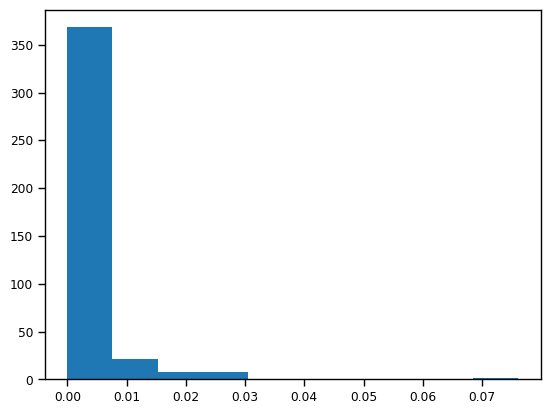

In [22]:
spikein_closest_match = pd.DataFrame(
    dict(
        idxmin_midas=spikein_to_midas_gdist.idxmin(axis=1),
        min_dist_midas=spikein_to_midas_gdist.min(axis=1),
        idxmin_isolate=spikein_to_midas_ecoli_isolate_gdist.idxmin(axis=1),
        min_dist_isolate=spikein_to_midas_ecoli_isolate_gdist.min(axis=1),
        idxmin_hmp2=spikein_to_hmp2_gdist.idxmin(axis=1),
        min_dist_hmp2=spikein_to_hmp2_gdist.min(axis=1),
    )
)

plt.hist(spikein_closest_match.min_dist_midas)

spikein_closest_match.sort_values("min_dist_midas", ascending=False)

In [23]:
unique_closest_match_spikein = spikein_closest_match.sort_values(
    "min_dist_midas", ascending=False
).drop_duplicates(subset=["idxmin_midas"])


spikein_benchmark_isolate_genomes = list(
    unique_closest_match_spikein.head(20).index
) + list(unique_closest_match_spikein.head(50).tail(5).index)

spikein_closest_match.loc[spikein_benchmark_isolate_genomes]

,idxmin_midas,min_dist_midas,idxmin_isolate,min_dist_isolate,idxmin_hmp2,min_dist_hmp2
Escherichia-coli-GCF_030205515-1,GUT_GENOME194678,0.076110,GUT_GENOME144360,0.085453,5,0.034443
Escherichia-coli-GCF_030205285-1,GUT_GENOME144552,0.028486,GUT_GENOME144552,0.028486,5,0.011587
Escherichia-coli-GCF_030198395-1,GUT_GENOME199418,0.026825,GUT_GENOME140930,0.119483,5,0.097022
Escherichia-coli-GCF_030204185-1,GUT_GENOME035670,0.022154,GUT_GENOME143925,0.027148,158,0.095790
Escherichia-coli-GCF_030201135-1,GUT_GENOME286391,0.020765,GUT_GENOME145443,0.027403,32,0.039218
Escherichia-coli-GCF_030198945-1,GUT_GENOME105961,0.016044,GUT_GENOME144186,0.115264,5,0.101509
Escherichia-coli-GCF_030203915-1,GUT_GENOME143925,0.015014,GUT_GENOME143925,0.015014,158,0.081114
Escherichia-coli-GCF_030206095-1,GUT_GENOME144469,0.014837,GUT_GENOME144469,0.014837,55,0.112472
Escherichia-coli-GCF_030202465-1,GUT_GENOME123294,0.013044,GUT_GENOME144880,0.041572,5,0.011749
Escherichia-coli-GCF_030202085-1,GUT_GENOME271261,0.011902,GUT_GENOME143925,0.020054,158,0.089470


In [25]:
spikein_to_spikein_gdist = pd.DataFrame(
    native_masked_hamming_distance_cdist(
        spikein_and_midas_geno.sel(strain=spikein_assembly_geno.strain).values,
        spikein_and_midas_geno.sel(strain=spikein_assembly_geno.strain).values,
    ),
    index=spikein_assembly_geno.strain,
    columns=spikein_assembly_geno.strain,
)

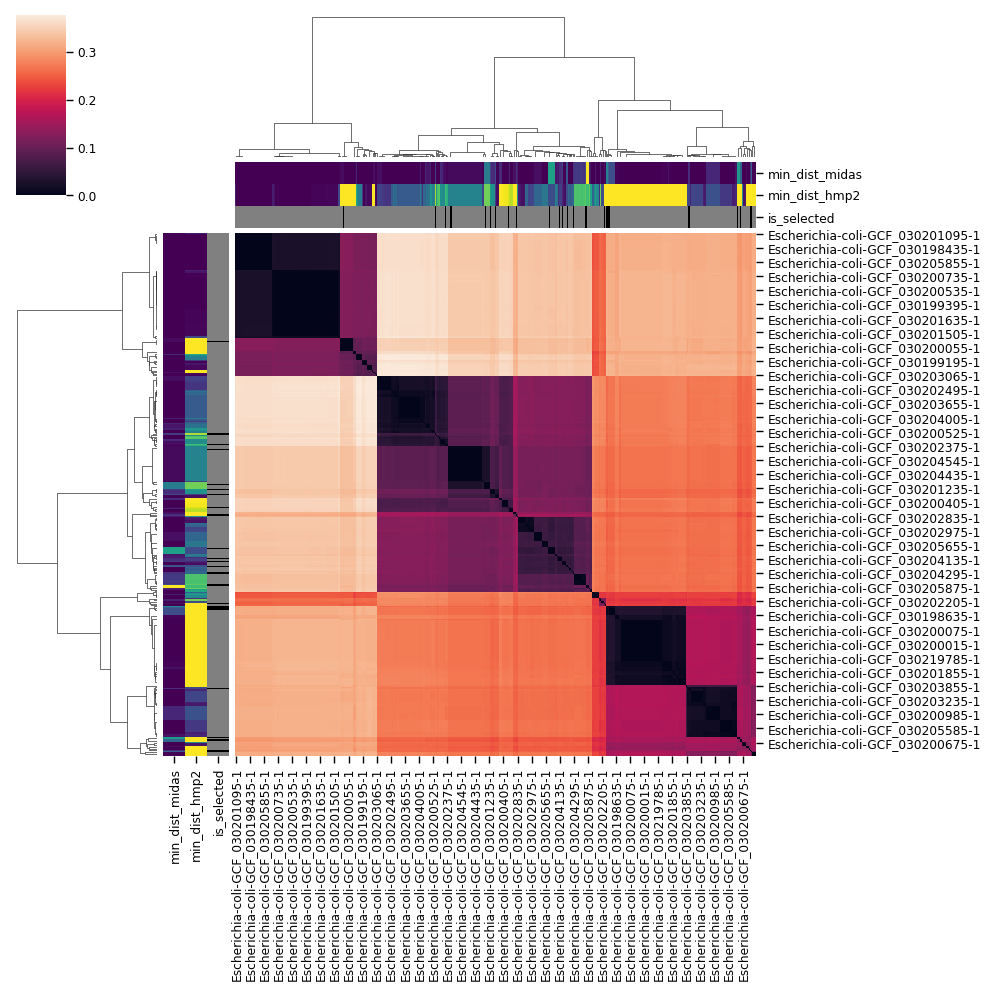

In [27]:
_colors = pd.DataFrame(
    dict(
        min_dist_midas=spikein_closest_match.min_dist_midas.map(
            lambda x: mpl.cm.viridis(x * 20)
        ),
        min_dist_hmp2=spikein_closest_match.min_dist_hmp2.map(
            lambda x: mpl.cm.viridis(x * 20)
        ),
        is_selected=spikein_closest_match.index.to_series()
        .isin(spikein_benchmark_isolate_genomes)
        .map({False: "grey", True: "black"}),
    )
)

sns.clustermap(spikein_to_spikein_gdist, col_colors=_colors, row_colors=_colors)

In [28]:
d = prjna938932_genomes.assign(
    genome_id=lambda x: "Escherichia-coli-"
    + x.assembly_id.str.replace("GCA", "GCF").str.replace(".1$", "-1", regex=True),
    mgen_id=lambda x: x.genome_id,
    species_id="102506",
    genome_path=lambda x: "raw/genomes/ncbi/" + x.genome_id + "/assembly.fa",
    r1_path=lambda x: "raw/genomes/ncbi/" + x.genome_id + "/r1.fq.gz",
    r2_path=lambda x: "raw/genomes/ncbi/" + x.genome_id + "/r2.fq.gz",
    genome_group_id="potential_spikein_benchmark",
    mgen_group_id="potential_spikein_benchmark",
    preprocessing="noop",
    _old_genome_id="",
    ncbi_assembly_name=lambda x: x.assembly_id,
    ncbi_assembly_biosample=lambda x: x.biosample,
    comments=lambda x: "From PRJNA938932 " + x.assembly_id + ";",
)[lambda x: x.genome_id.isin(spikein_benchmark_isolate_genomes)].sort_values(
    "genome_id"
)


d[genome_meta.columns].to_csv("meta/bench_ecoli_genome.tsv", index=False, sep="\t")
d[genome_group_meta.columns].to_csv(
    "meta/bench_ecoli_genome_group.tsv", index=False, sep="\t"
)
d[mgen_group_meta.columns].to_csv(
    "meta/bench_ecoli_mgen_group.tsv", index=False, sep="\t"
)
d[mgen_meta.columns].to_csv("meta/bench_ecoli_mgen_to_reads.tsv", index=False, sep="\t")

## Select a subject with 5+ samples and no E. coli

In [29]:
species_list = (
    pd.read_table("meta/species_group.tsv")[lambda x: x.species_group_id == "hmp2"]
    .species_id.astype(str)
    .unique()
)

In [30]:
mgen = pd.read_table("meta/hmp2/mgen.tsv", index_col="library_id")
preparation = pd.read_table("meta/hmp2/preparation.tsv", index_col="preparation_id")
stool = pd.read_table("meta/hmp2/stool.tsv", index_col="stool_id")
visit = pd.read_table("meta/hmp2/visit.tsv", index_col="visit_id")
subject = pd.read_table("meta/hmp2/subject.tsv", index_col="subject_id")

meta_all = (
    mgen.join(preparation.drop(columns="library_type"), on="preparation_id")
    .join(stool, on="stool_id")
    .join(visit, on="visit_id", rsuffix="_")
    .join(subject, on="subject_id")
    .assign(
        new_name=lambda x: (
            x[["subject_id", "week_number"]]
            .assign(library_id=x.index)
            .assign(week_number=lambda x: x.week_number.fillna(999).astype(int))
            .apply(lambda x: "_".join(x.astype(str)), axis=1)
        )
    )
    # .reset_index()
    # .set_index('new_name')
)

library_id_to_new_name = meta_all.new_name

assert not any(meta_all.subject_id.isna())

# TODO: Rename samples based on subject and visit number
# TODO: Drop duplicate stools

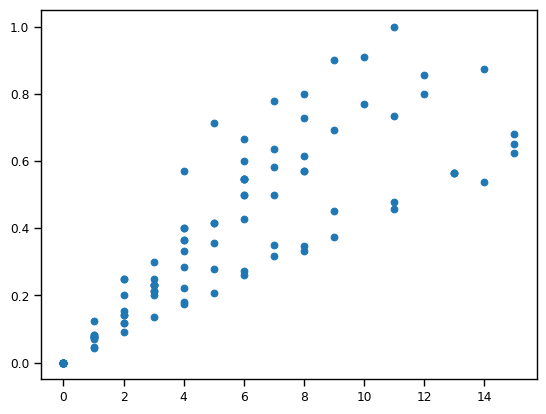

In [31]:
species_depth_inpath = f"data/group/hmp2/species/sp-{species}/r.proc.gene99_v20-v23-agg75.spgc_specgene-ref-filt-p95.species_depth.tsv"
species_depth = pd.read_table(
    species_depth_inpath, names=["library_id", "species_depth"], index_col="library_id"
).squeeze()

d = (
    meta_all.assign(
        species_depth=species_depth, species_missing=lambda x: x.species_depth == 0
    )
    .groupby("subject_id")
    .species_missing.agg(["mean", "sum"])
)

plt.scatter("sum", "mean", data=d)

In [32]:
d.sort_values("sum", ascending=False)

,mean,sum
subject_id,,
C3022,0.681818,15
M2072,0.625000,15
H4020,0.652174,15
M2068,0.538462,14
P6005,0.875000,14
...,...,...
M2024,0.000000,0
M2027,0.000000,0
M2034,0.000000,0


In [33]:
meta_all.assign(
    species_depth=species_depth, species_missing=lambda x: x.species_depth == 0
)[lambda x: (x.subject_id == "C3022") & (x.species_depth == 0)]

,external_id,library_type,number_of_lanes_aggregated,sequenced_reads,preparation_id,r1_path,r2_path,project_name,stool_id,visit_id,...,status_smoker,status_smoker_years,history_smoker_age_at_start,status_smoker_number_per_day,baseline_height,baseline_weight,history_smoker,new_name,species_depth,species_missing
library_id,,,,,,,,,,,,,,,,,,,,,
CSM79HGX_G116737,CSM79HGX,metagenomics,NaN,7585660.0,CSM79HGX_G116737,raw/mgen/hmp2/CSM79HGX_R1.fastq.gz,raw/mgen/hmp2/CSM79HGX_R2.fastq.gz,G116737,CSM79HGX,C3022C4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C3022_8_CSM79HGX_G116737,0.0,True
CSM79HGZ_G116733,CSM79HGZ,metagenomics,NaN,10479201.0,CSM79HGZ_G116733,raw/mgen/hmp2/CSM79HGZ_R1.fastq.gz,raw/mgen/hmp2/CSM79HGZ_R2.fastq.gz,G116733,CSM79HGZ,C3022C5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C3022_10_CSM79HGZ_G116733,0.0,True
CSM79HOV_G110595,CSM79HOV,metagenomics,NaN,8389676.0,CSM79HOV_G110595,raw/mgen/hmp2/CSM79HOV_R1.fastq.gz,raw/mgen/hmp2/CSM79HOV_R2.fastq.gz,G110595,CSM79HOV,C3022C6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C3022_12_CSM79HOV_G110595,0.0,True
CSM79HOX_G110583,CSM79HOX,metagenomics,NaN,20958039.0,CSM79HOX_G110583,raw/mgen/hmp2/CSM79HOX_R1.fastq.gz,raw/mgen/hmp2/CSM79HOX_R2.fastq.gz,G110583,CSM79HOX,C3022C7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C3022_14_CSM79HOX_G110583,0.0,True
CSM79HOZ_G116676,CSM79HOZ,metagenomics,NaN,13674571.0,CSM79HOZ_G116676,raw/mgen/hmp2/CSM79HOZ_R1.fastq.gz,raw/mgen/hmp2/CSM79HOZ_R2.fastq.gz,G116676,CSM79HOZ,C3022C9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C3022_16_CSM79HOZ_G116676,0.0,True
CSM79HP2_G110568,CSM79HP2,metagenomics,NaN,32444092.0,CSM79HP2_G110568,raw/mgen/hmp2/CSM79HP2_R1.fastq.gz,raw/mgen/hmp2/CSM79HP2_R2.fastq.gz,G110568,CSM79HP2,C3022C10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C3022_18_CSM79HP2_G110568,0.0,True
CSM79HP4_G116738,CSM79HP4,metagenomics,NaN,8871880.0,CSM79HP4_G116738,raw/mgen/hmp2/CSM79HP4_R1.fastq.gz,raw/mgen/hmp2/CSM79HP4_R2.fastq.gz,G116738,CSM79HP4,C3022C11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C3022_21_CSM79HP4_G116738,0.0,True
CSM79HP6_G110610,CSM79HP6,metagenomics,NaN,11545593.0,CSM79HP6_G110610,raw/mgen/hmp2/CSM79HP6_R1.fastq.gz,raw/mgen/hmp2/CSM79HP6_R2.fastq.gz,G110610,CSM79HP6,C3022C12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C3022_23_CSM79HP6_G110610,0.0,True
CSM7KOOJ_G110618,CSM7KOOJ,metagenomics,NaN,21887596.0,CSM7KOOJ_G110618,raw/mgen/hmp2/CSM7KOOJ_R1.fastq.gz,raw/mgen/hmp2/CSM7KOOJ_R2.fastq.gz,G110618,CSM7KOOJ,C3022C15,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C3022_28_CSM7KOOJ_G110618,0.0,True


In [34]:
spikein_mapping = pd.read_table('data/group/hmp2_spikein_benchmark/species/sp-102506/ecoli-spiked.strain_samples.tsv', names=['sample', 'strain'], index_col='sample').strain
spikein_mapping

sample
CSM79HGX_G116737_spikein_Escherichia-coli-GCF_030205875-1_seed0_cov01    Escherichia-coli-GCF_030205875-1
CSM79HGZ_G116733_spikein_Escherichia-coli-GCF_030205875-1_seed1_cov02    Escherichia-coli-GCF_030205875-1
CSM79HOV_G110595_spikein_Escherichia-coli-GCF_030205875-1_seed2_cov04    Escherichia-coli-GCF_030205875-1
CSM79HOX_G110583_spikein_Escherichia-coli-GCF_030205875-1_seed3_cov08    Escherichia-coli-GCF_030205875-1
CSM79HOZ_G116676_spikein_Escherichia-coli-GCF_030205875-1_seed4_cov16    Escherichia-coli-GCF_030205875-1
CSM79HGX_G116737_spikein_Escherichia-coli-GCF_030205145-1_seed0_cov01    Escherichia-coli-GCF_030205145-1
CSM79HGZ_G116733_spikein_Escherichia-coli-GCF_030205145-1_seed1_cov02    Escherichia-coli-GCF_030205145-1
CSM79HOV_G110595_spikein_Escherichia-coli-GCF_030205145-1_seed2_cov04    Escherichia-coli-GCF_030205145-1
CSM79HOX_G110583_spikein_Escherichia-coli-GCF_030205145-1_seed3_cov08    Escherichia-coli-GCF_030205145-1
CSM79HOZ_G116676_spikein_Escherichia-co

In [35]:
spikein_closest_match.loc[spikein_mapping.unique()]

,idxmin_midas,min_dist_midas,idxmin_isolate,min_dist_isolate,idxmin_hmp2,min_dist_hmp2
Escherichia-coli-GCF_030205875-1,GUT_GENOME194678,0.076110,GUT_GENOME144360,0.085452,5,0.034437
Escherichia-coli-GCF_030205145-1,GUT_GENOME144552,0.028486,GUT_GENOME144552,0.028486,5,0.011587
Escherichia-coli-GCF_030202075-1,GUT_GENOME140957,0.008261,GUT_GENOME140957,0.008261,5,0.035896
Escherichia-coli-GCF_030198905-1,GUT_GENOME045881,0.005001,GUT_GENOME144050,0.010249,54,0.015677
Escherichia-coli-GCF_030204715-1,GUT_GENOME098742,0.000746,GUT_GENOME140937,0.001513,71,0.047646


In [36]:
uhgg_genome_meta.loc[spikein_closest_match.loc[spikein_mapping.unique()].idxmin_midas]
# uhgg_genome_meta.loc[spikein_closest_match.loc[spikein_mapping.unique()].idxmin_midas]

,Genome,Genome_type,Length,N_contigs,N50,GC_content,Completeness,Contamination,rRNA_5S,rRNA_16S,...,tRNAs,Genome_accession,Species_rep,Lineage,Sample_accession,Study_accession,Country,Continent,FTP_download,mg2to1
New_Genome_accession,,,,,,,,,,,,,,,,,,,,,
GUT_GENOME194678,MGYG000050459,MAG,2909943,581,5823,51.06,68.93,0.54,0.0,0.00,...,16,GUT_GENOME194678,MGYG000002506,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,SRS1822120,SRP094017,United States,North America,ftp://ftp.ebi.ac.uk/pub/databases/metagenomics...,GUT_GENOME194678
GUT_GENOME144552,MGYG000063371,Isolate,5167951,1,5167951,50.78,99.47,0.10,95.8,99.67,...,20,GUT_GENOME144552,MGYG000002506,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,SAMN02991250,PRJNA218110,United States,North America,ftp://ftp.ebi.ac.uk/pub/databases/metagenomics...,GUT_GENOME144552
GUT_GENOME140957,MGYG000013248,Isolate,4880986,64,166268,50.98,99.97,0.36,95.8,99.67,...,20,GUT_GENOME140957,MGYG000002506,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,SAMN00854653,PRJNA164945,Denmark,Europe,ftp://ftp.ebi.ac.uk/pub/databases/metagenomics...,GUT_GENOME140957
GUT_GENOME045881,MGYG000282505,MAG,2057346,122,25833,51.53,52.08,0.26,0.0,0.00,...,15,GUT_GENOME045881,MGYG000002506,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,ERS1343347,ERP017091,China,Asia,ftp://ftp.ebi.ac.uk/pub/databases/metagenomics...,GUT_GENOME045881
GUT_GENOME098742,MGYG000085405,MAG,3208250,73,84654,51.12,74.30,0.63,0.0,0.00,...,16,GUT_GENOME098742,MGYG000002506,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,ERS1343321,ERP017091,China,Asia,ftp://ftp.ebi.ac.uk/pub/databases/metagenomics...,GUT_GENOME098742


In [37]:
uhgg_genome_meta.loc[spikein_closest_match.loc[spikein_mapping.unique()].idxmin_midas]

,Genome,Genome_type,Length,N_contigs,N50,GC_content,Completeness,Contamination,rRNA_5S,rRNA_16S,...,tRNAs,Genome_accession,Species_rep,Lineage,Sample_accession,Study_accession,Country,Continent,FTP_download,mg2to1
New_Genome_accession,,,,,,,,,,,,,,,,,,,,,
GUT_GENOME194678,MGYG000050459,MAG,2909943,581,5823,51.06,68.93,0.54,0.0,0.00,...,16,GUT_GENOME194678,MGYG000002506,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,SRS1822120,SRP094017,United States,North America,ftp://ftp.ebi.ac.uk/pub/databases/metagenomics...,GUT_GENOME194678
GUT_GENOME144552,MGYG000063371,Isolate,5167951,1,5167951,50.78,99.47,0.10,95.8,99.67,...,20,GUT_GENOME144552,MGYG000002506,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,SAMN02991250,PRJNA218110,United States,North America,ftp://ftp.ebi.ac.uk/pub/databases/metagenomics...,GUT_GENOME144552
GUT_GENOME140957,MGYG000013248,Isolate,4880986,64,166268,50.98,99.97,0.36,95.8,99.67,...,20,GUT_GENOME140957,MGYG000002506,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,SAMN00854653,PRJNA164945,Denmark,Europe,ftp://ftp.ebi.ac.uk/pub/databases/metagenomics...,GUT_GENOME140957
GUT_GENOME045881,MGYG000282505,MAG,2057346,122,25833,51.53,52.08,0.26,0.0,0.00,...,15,GUT_GENOME045881,MGYG000002506,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,ERS1343347,ERP017091,China,Asia,ftp://ftp.ebi.ac.uk/pub/databases/metagenomics...,GUT_GENOME045881
GUT_GENOME098742,MGYG000085405,MAG,3208250,73,84654,51.12,74.30,0.63,0.0,0.00,...,16,GUT_GENOME098742,MGYG000002506,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,ERS1343321,ERP017091,China,Asia,ftp://ftp.ebi.ac.uk/pub/databases/metagenomics...,GUT_GENOME098742


In [38]:
w = sf.data.World.load(
    "data/group/hmp2_spikein_benchmark/species/sp-102506/r.proc.gtpro.filt-poly05-cvrg05.ss-g10000-block0-seed0.fit-sfacts37-s85-seed0.world.nc"
)

genome_to_strain = w.sel(sample=spikein_mapping.index).community.to_pandas().groupby(spikein_mapping).mean().idxmax(1)
genome_to_strain

strain
Escherichia-coli-GCF_030198905-1    37
Escherichia-coli-GCF_030202075-1    31
Escherichia-coli-GCF_030204715-1    53
Escherichia-coli-GCF_030205145-1    19
Escherichia-coli-GCF_030205875-1    35
dtype: int64

In [39]:
genome_to_strain.index.values

array(['Escherichia-coli-GCF_030198905-1',
       'Escherichia-coli-GCF_030202075-1',
       'Escherichia-coli-GCF_030204715-1',
       'Escherichia-coli-GCF_030205145-1',
       'Escherichia-coli-GCF_030205875-1'], dtype=object)

In [40]:
spikein_performance = []

for genome, strain in genome_to_strain.items():
    inpath = f'data/group/hmp2_spikein_benchmark/species/sp-102506/r.proc.gtpro.filt-poly05-cvrg05.ss-g10000-block0-seed0.fit-sfacts37-s85-seed0.gene99_v20-v23-agg75.spgc_specgene-ref-filt-p95_ss-all_t-10_thresh-corr400-depth200.{genome}.eggnog-reconstruction_accuracy.tsv'
    benchmark = pd.read_table(inpath, index_col='strain').assign(genome_id=genome)
    print(inpath)
    # print(benchmark.loc[strain])
    # print(spikein_closest_match.loc[genome])
    # print()
    spikein_performance.append(benchmark.loc[strain].to_dict() | spikein_closest_match.loc[genome].to_dict())

spikein_performance = pd.DataFrame(spikein_performance)

print(spikein_performance[['precision', 'recall', 'f1']].mean())
spikein_performance

data/group/hmp2_spikein_benchmark/species/sp-102506/r.proc.gtpro.filt-poly05-cvrg05.ss-g10000-block0-seed0.fit-sfacts37-s85-seed0.gene99_v20-v23-agg75.spgc_specgene-ref-filt-p95_ss-all_t-10_thresh-corr400-depth200.Escherichia-coli-GCF_030198905-1.eggnog-reconstruction_accuracy.tsv
data/group/hmp2_spikein_benchmark/species/sp-102506/r.proc.gtpro.filt-poly05-cvrg05.ss-g10000-block0-seed0.fit-sfacts37-s85-seed0.gene99_v20-v23-agg75.spgc_specgene-ref-filt-p95_ss-all_t-10_thresh-corr400-depth200.Escherichia-coli-GCF_030202075-1.eggnog-reconstruction_accuracy.tsv
data/group/hmp2_spikein_benchmark/species/sp-102506/r.proc.gtpro.filt-poly05-cvrg05.ss-g10000-block0-seed0.fit-sfacts37-s85-seed0.gene99_v20-v23-agg75.spgc_specgene-ref-filt-p95_ss-all_t-10_thresh-corr400-depth200.Escherichia-coli-GCF_030204715-1.eggnog-reconstruction_accuracy.tsv
data/group/hmp2_spikein_benchmark/species/sp-102506/r.proc.gtpro.filt-poly05-cvrg05.ss-g10000-block0-seed0.fit-sfacts37-s85-seed0.gene99_v20-v23-agg75.spg

,n_tp,n_fp,n_fn,f1,precision,recall,jaccard,genome_id,idxmin_midas,min_dist_midas,idxmin_isolate,min_dist_isolate,idxmin_hmp2,min_dist_hmp2
0,14810.0,456.0,2188.0,0.918051,0.970130,0.871279,0.848516,Escherichia-coli-GCF_030198905-1,GUT_GENOME045881,0.005001,GUT_GENOME144050,0.010249,54,0.015677
1,14171.0,543.0,2086.0,0.915114,0.963096,0.871686,0.843512,Escherichia-coli-GCF_030202075-1,GUT_GENOME140957,0.008261,GUT_GENOME140957,0.008261,5,0.035896
2,15019.0,533.0,3195.0,0.889593,0.965728,0.824585,0.801142,Escherichia-coli-GCF_030204715-1,GUT_GENOME098742,0.000746,GUT_GENOME140937,0.001513,71,0.047646
3,15318.0,609.0,2259.0,0.914398,0.961763,0.871480,0.842296,Escherichia-coli-GCF_030205145-1,GUT_GENOME144552,0.028486,GUT_GENOME144552,0.028486,5,0.011587
4,14994.0,524.0,2162.0,0.917794,0.966233,0.873980,0.848077,Escherichia-coli-GCF_030205875-1,GUT_GENOME194678,0.076110,GUT_GENOME144360,0.085452,5,0.034437


In [41]:
print(spikein_performance[['genome_id', 'idxmin_midas', 'min_dist_midas', 'precision', 'recall', 'f1']].to_markdown())

|    | genome_id                        | idxmin_midas     |   min_dist_midas |   precision |   recall |       f1 |
|---:|:---------------------------------|:-----------------|-----------------:|------------:|---------:|---------:|
|  0 | Escherichia-coli-GCF_030198905-1 | GUT_GENOME045881 |      0.00500071  |    0.97013  | 0.871279 | 0.918051 |
|  1 | Escherichia-coli-GCF_030202075-1 | GUT_GENOME140957 |      0.00826054  |    0.963096 | 0.871686 | 0.915114 |
|  2 | Escherichia-coli-GCF_030204715-1 | GUT_GENOME098742 |      0.000745725 |    0.965728 | 0.824585 | 0.889593 |
|  3 | Escherichia-coli-GCF_030205145-1 | GUT_GENOME144552 |      0.0284859   |    0.961763 | 0.87148  | 0.914398 |
|  4 | Escherichia-coli-GCF_030205875-1 | GUT_GENOME194678 |      0.0761096   |    0.966233 | 0.87398  | 0.917794 |


In [42]:
spikein_performance[['precision', 'recall', 'f1']].median()

precision    0.965728
recall       0.871480
f1           0.915114
dtype: float64

In [43]:
uhgg_genome_meta.loc[spikein_performance.idxmin_isolate]

,Genome,Genome_type,Length,N_contigs,N50,GC_content,Completeness,Contamination,rRNA_5S,rRNA_16S,...,tRNAs,Genome_accession,Species_rep,Lineage,Sample_accession,Study_accession,Country,Continent,FTP_download,mg2to1
New_Genome_accession,,,,,,,,,,,,,,,,,,,,,
GUT_GENOME144050,MGYG000181025,Isolate,4957041,295,85494,50.60,99.87,0.41,95.8,99.67,...,19,GUT_GENOME144050,MGYG000002506,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,SAMN04279428,PRJNA230969,United States,North America,ftp://ftp.ebi.ac.uk/pub/databases/metagenomics...,GUT_GENOME144050
GUT_GENOME140957,MGYG000013248,Isolate,4880986,64,166268,50.98,99.97,0.36,95.8,99.67,...,20,GUT_GENOME140957,MGYG000002506,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,SAMN00854653,PRJNA164945,Denmark,Europe,ftp://ftp.ebi.ac.uk/pub/databases/metagenomics...,GUT_GENOME140957
GUT_GENOME140937,MGYG000078064,Isolate,5116882,88,110178,50.94,99.97,0.62,95.8,99.67,...,20,GUT_GENOME140937,MGYG000002506,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,SAMN00854632,PRJNA164903,Denmark,Europe,ftp://ftp.ebi.ac.uk/pub/databases/metagenomics...,GUT_GENOME140937
GUT_GENOME144552,MGYG000063371,Isolate,5167951,1,5167951,50.78,99.47,0.10,95.8,99.67,...,20,GUT_GENOME144552,MGYG000002506,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,SAMN02991250,PRJNA218110,United States,North America,ftp://ftp.ebi.ac.uk/pub/databases/metagenomics...,GUT_GENOME144552
GUT_GENOME144360,MGYG000259207,Isolate,4852001,198,67325,50.64,99.62,0.14,95.8,93.87,...,20,GUT_GENOME144360,MGYG000002506,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,SAMN04992996,PRJNA230969,Mexico,North America,ftp://ftp.ebi.ac.uk/pub/databases/metagenomics...,GUT_GENOME144360


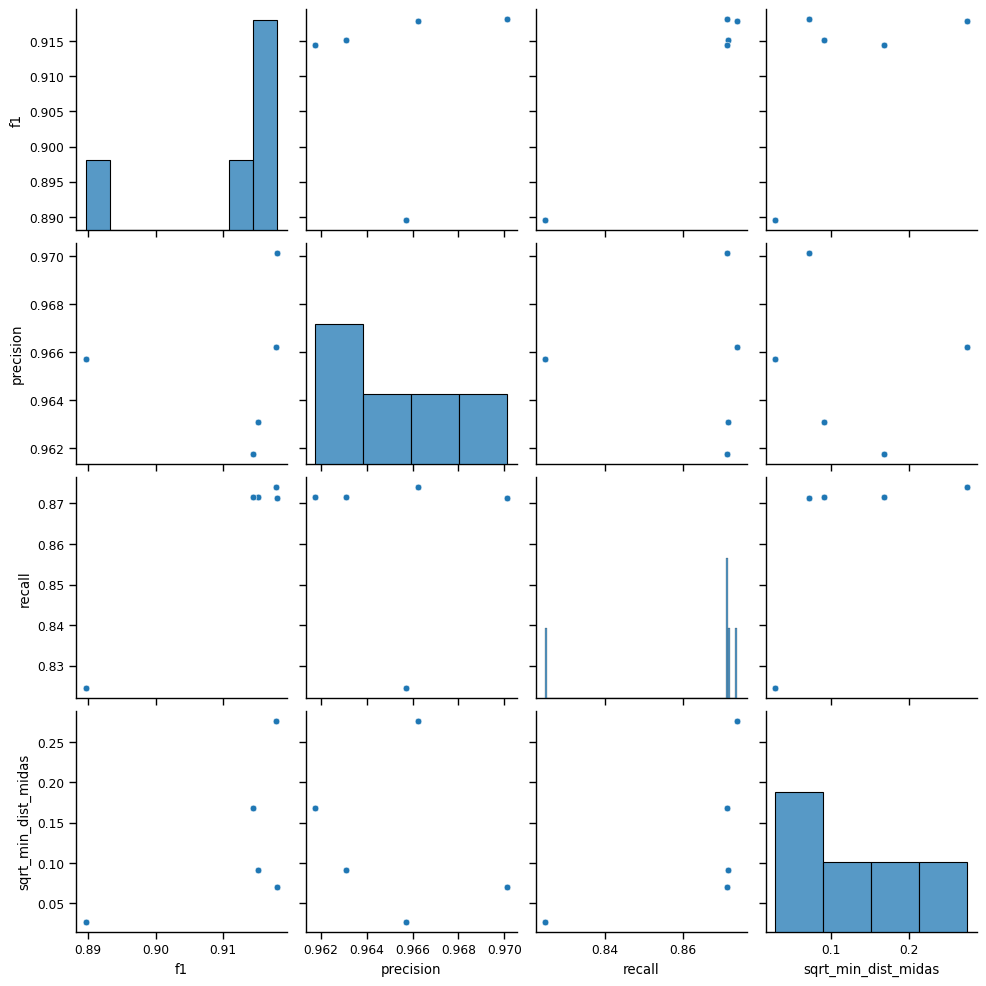

In [45]:
sns.pairplot(spikein_performance.assign(sqrt_min_dist_midas=lambda x: np.sqrt(x.min_dist_midas))[['f1', 'precision', 'recall', 'sqrt_min_dist_midas']])

In [46]:
for genome_id, midas_id in spikein_performance[['genome_id', 'idxmin_midas']].values:
    g = spikein_and_midas_geno.sel(strain=[genome_id, midas_id]).data
    shared_positions = idxwhere(~g.pipe(np.isnan).any("strain").to_series())
    num_mismatched, num_shared = (
        (g.sel(strain=genome_id) != g.sel(strain=midas_id)).sel(position=shared_positions).sum(),
        len(shared_positions)
    )
    print(
        genome_id,
        midas_id,
        num_mismatched,
        num_shared,
        (num_mismatched + 1) / (num_shared + 1)
    )

Escherichia-coli-GCF_030198905-1 GUT_GENOME045881 <xarray.DataArray 'metagenotype' ()>
array(176) 35195 <xarray.DataArray 'metagenotype' ()>
array(0.00502898)
Escherichia-coli-GCF_030202075-1 GUT_GENOME140957 <xarray.DataArray 'metagenotype' ()>
array(627) 75903 <xarray.DataArray 'metagenotype' ()>
array(0.00827361)
Escherichia-coli-GCF_030204715-1 GUT_GENOME098742 <xarray.DataArray 'metagenotype' ()>
array(45) 60344 <xarray.DataArray 'metagenotype' ()>
array(0.00076228)
Escherichia-coli-GCF_030205145-1 GUT_GENOME144552 <xarray.DataArray 'metagenotype' ()>
array(2283) 80145 <xarray.DataArray 'metagenotype' ()>
array(0.02849799)
Escherichia-coli-GCF_030205875-1 GUT_GENOME194678 <xarray.DataArray 'metagenotype' ()>
array(3865) 50782 <xarray.DataArray 'metagenotype' ()>
array(0.07612784)
